## 曲率がパイプの振動特性に与える影響の解析

このノートブックでは、パイプの曲げ加工によって生じる肉厚の変化が、パイプの固有振動数や周波数応答にどのような影響を与えるかを比較・分析します。

- **Case 1:** パイプ全体の肉厚が均一であると仮定したモデル
- **Case 2:** 曲率に応じて肉厚が変化することを考慮したモデル

### Step 1: ライブラリのインポート

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import sys
import os

# プロジェクトのルートディレクトリをPythonパスに追加
project_root = os.path.abspath(os.path.join(os.getcwd(), '..'))
if project_root not in sys.path:
    sys.path.append(project_root)

from pipeVibSim.pipe_path import PipePath
from pipeVibSim.pipe import Pipe
from pipeVibSim.simulation import VibrationAnalysis
import pipeVibSim.postprocessing as post

# 3Dプロット設定
from mpl_toolkits.mplot3d import Axes3D

### Step 2: パイプ形状と材料特性の定義

In [2]:
# セグメント1: 90度曲げ
points1 = np.array([
    [0, 0, 0],
    [1, 0, 0],
    [1, 1, 0]
], dtype=float)
path1 = PipePath(points=points1, radius=0.3, step=0.05)

# セグメント2: 180度Uベンド
points2 = np.array([
    [0, 0, 0],
    [0, 0.2, 0],
    [0.4, 0.2, 0],
    [0.4, -1, 0]
], dtype=float) + np.array([1, 1, 0])  # セグメント1の終点にオフセット
path2 = PipePath(points=points2, radius=0.2, step=0.05)

# 2つのパスを結合
combined_path = path1 + path2

# 材料特性
material_props_base = {
    'young_modulus': 2.06e11,  # Pa
    'poisson_ratio': 0.3,
    'density': 7850,         # kg/m^3
    'outer_diameter': 0.1143 # m (4インチ)
}

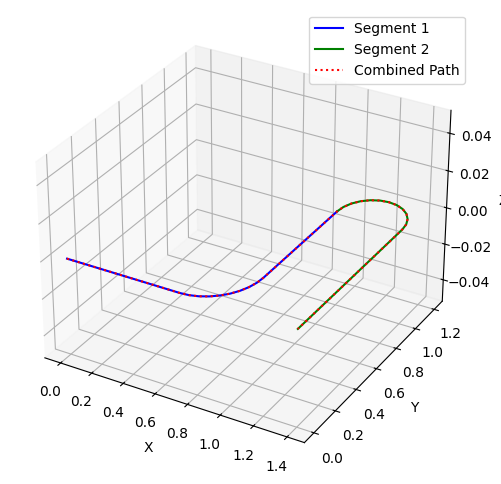

In [64]:
fig, ax =post.plot_node_path(path1.node_positions)
fig, ax =post.plot_node_path(path2.node_positions, fig=fig, ax=ax, color='green')
fig, ax =post.plot_node_path(combined_path.node_positions, fig=fig, ax=ax, color='red')
# 最後にプロットされたラインを取得
last_line = ax.get_lines()[-1]
# ラインスタイルをドット（点線）に変更
last_line.set_linestyle(':')  # ':' はドットスタイル
ax.legend(['Segment 1', 'Segment 2', 'Combined Path'])

### Step 3: Case 1 - 均一な肉厚での解析

In [ ]:
# Case 1: 均一な肉厚
material_case1 = material_props_base.copy()
material_case1['thickness'] = 0.006 # 6mm (Schedule 40)

pipe_case1 = Pipe(combined_path, material_case1)

# 解析の実行
analysis1 = VibrationAnalysis(pipe_case1)
constraints = [(pipe_case1.node_positions[0], None)] # 始点を完全固定
analysis1.substructure_by_coordinate(constraints)
shapes1 = analysis1.run_eigensolution(maximum_frequency=200)


In [ ]:
# 固有値解析結果のプロット
post.plot_mode_shapes(analysis1.geometry, shapes1)

In [11]:
# FRFの計算 (example.ipynbの流儀に合わせる)
# 終端から4番目の自由度(z方向並進と仮定)を加振し、同じ点を応答点とする
input_dof = -4
all_dofz = slice(None)

frequencies = np.linspace(0.001, 100, 100)
frf1 = analysis1.run_frf(frequencies, load_dof_indices=input_dof, response_dof_indices=all_dofz)

In [12]:
post.plot_deflection_shape(analysis1.geometry,frf=frf1)

### Step 4: Case 2 - 曲率に応じた肉厚での解析

In [25]:
# Case 2: 曲率に応じて肉厚を変化
material_case2 = material_props_base.copy()
curvatures = combined_path.curvatures
nominal_thickness = 0.006

# 曲率が最大(1/radius)の箇所で15%肉厚が減少すると仮定
max_curvature = np.max(curvatures)
reduction_factor = 0.15 / max_curvature if max_curvature > 0 else 0

thickness_list = nominal_thickness * (1 - curvatures * reduction_factor)
material_case2['thickness'] = thickness_list

pipe_case2 = Pipe(combined_path, material_case2)

# 解析の実行
analysis2 = VibrationAnalysis(pipe_case2)
analysis2.substructure_by_coordinate(constraints) # Case 1と同じ境界条件
shapes2 = analysis2.run_eigensolution(maximum_frequency=200)


In [26]:
# 固有値解析結果のプロット
post.plot_mode_shapes(analysis2.geometry, shapes2)

In [29]:
# FRFの計算
frf2 = analysis2.run_frf(frequencies, load_dof_indices=[input_dof], response_dof_indices=all_dofz)


In [51]:
post.plot_deflection_shape(analysis2.geometry,frf=frf2)

### Step 5: 結果の比較と可視化

#### 周波数応答関数（FRF）の比較

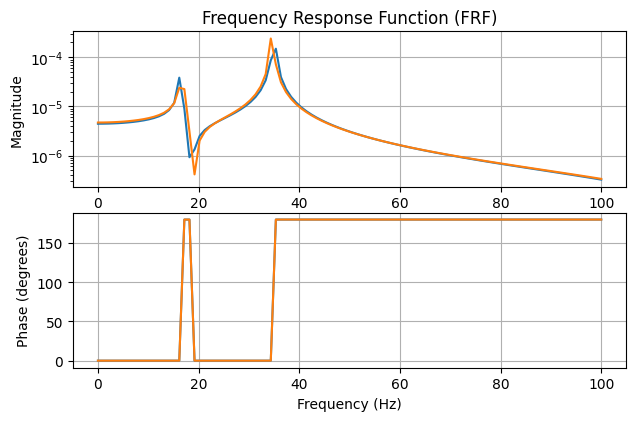

In [70]:
fig, ax = post.plot_frf(frf1[-4, :], fig=fig)
fig, ax = post.plot_frf(frf2[-4, :], fig=fig, axes=ax)
fig.set_size_inches(6,4)

#### モード形状の比較

In [62]:
glist = [analysis1.geometry, analysis2.geometry]
dlist = [frf1, frf2]
post.plot_multiple_deflection_shapes(glist,dlist )